In [114]:
%matplotlib widget
import geopandas as gpd
import os
import rasterio
from rasterio.plot import show
from shapely.geometry import LineString
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from adjustText import adjust_text
from shapely.geometry import Point
import numpy as np
import seaborn as sns
import variogram_tools
from itertools import combinations_with_replacement
from scipy.special import kv, gamma
from scipy.optimize import curve_fit
import pandas as pd

import folium
from folium import features, plugins
from shapely.geometry import shape, Polygon, LineString, Point
from pyproj import Transformer


import json

from ipyleaflet import Map, DrawControl,ImageOverlay
from shapely.geometry import shape



## Select profiles and stable areas on interactive map

In [107]:
data_path="test_data/"

In [119]:
# Load the TIF file
with rasterio.open(data_path+"topo_diff.tif") as dataset:
    # Read the raster data
    img = dataset.read(1)  # Read the first band

    # Get the bounds of the raster data in UTM
    bounds = dataset.bounds
    crs = dataset.crs

    # Create a transformer to convert from UTM to WGS84
    transformer = Transformer.from_crs(crs, 'EPSG:4326', always_xy=True)

    # Transform the bounds to lat/lon
    west, south = transformer.transform(bounds.left, bounds.bottom)
    east, north = transformer.transform(bounds.right, bounds.top)


# Map setup
m = Map(center=((north + south) / 2, (west + east) / 2), zoom=15, layout={'height':'800px', 'width':'1300px'})
draw_control = DrawControl()
draw_control.polyline = {"shapeOptions": {"color": "#6bc2e5", "weight": 8}}
draw_control.polygon = {"shapeOptions": {"fillColor": "#fca45d", "color": "#de8f05", "fillOpacity": 0.5}}
draw_control.rectangle = {"shapeOptions": {"fillColor": "#fca45d", "color": "#de8f05", "fillOpacity": 0.5}}
m.add_control(draw_control)

# Store Shapely objects
shapely_geometries = []

# Handler for drawn shapes
def handle_draw(target, action, geo_json):
    geom = shape(geo_json['geometry'])
    shapely_geometries.append(geom)
    print("Added shape:", geom)
    print("Number of shapes stored:", len(shapely_geometries))

draw_control.on_draw(handle_draw)

#Create an image overlay
overlay = ImageOverlay(
    url=data_path+"topo_diff.png",  # Path to the image file created from the raster data
    bounds=((south, west), (north, east))
)

# Add the overlay to the map
m.add_layer(overlay)

# Display map
m



Map(center=[43.60345346429935, -110.6854502479764], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Added shape: POLYGON ((-110.705581 43.614299, -110.705752 43.592701, -110.704808 43.593757, -110.70365 43.594783, -110.702233 43.59556, -110.701118 43.596026, -110.700259 43.59643, -110.699143 43.597083, -110.698414 43.597642, -110.697169 43.598575, -110.695968 43.600439, -110.695581 43.601589, -110.694809 43.603578, -110.692921 43.604852, -110.68996 43.606406, -110.688543 43.606934, -110.68717 43.607618, -110.685883 43.608053, -110.683608 43.60911, -110.680518 43.610881, -110.676827 43.612527, -110.675626 43.613957, -110.705581 43.614299))
Number of shapes stored: 1
Added shape: POLYGON ((-110.666785 43.609762, -110.667944 43.609296, -110.668588 43.608923, -110.668974 43.608208, -110.669575 43.607494, -110.670605 43.606686, -110.671248 43.606033, -110.672579 43.60535, -110.673308 43.604977, -110.672708 43.604573, -110.67142 43.604417, -110.670218 43.604169, -110.669017 43.60333, -110.667686 43.603174, -110.666742 43.603485, -110.666056 43.604728, -110.665755 43.606189, -110.665712 43.

In [120]:
shapely_geometries

[<POLYGON ((-110.706 43.614, -110.706 43.593, -110.705 43.594, -110.704 43.59...>,
 <POLYGON ((-110.667 43.61, -110.668 43.609, -110.669 43.609, -110.669 43.608...>,
 <POLYGON ((-110.672 43.599, -110.673 43.599, -110.674 43.598, -110.675 43.59...>,
 <LINESTRING (-110.676 43.598, -110.676 43.598, -110.676 43.599, -110.676 43....>]

## Import shapefiles

### Function to load shapefiles

In [92]:
def load_shapefiles(data_path, prefix, shp_number):
    """
    Load multiple shapefiles into a dictionary of GeoDataFrames.

    Parameters:
    - data_path (str): The path to the directory with the shapefiles.
    - prefix (str): The prefix (before the number) in the filenames giving the shapefile type.
    - shp_number (int): The number of shapefiles of that type to search for.

    Returns:
    - dict: A dictionary where keys are simplified filenames and values are GeoDataFrames.
    """
    gdfs = {}
    for i in range(1, shp_number + 1):  # Corrected to include shp_number
        filename = f"{prefix}{i}.shp"
        file_path = os.path.join(data_path, filename)  # Correct path construction
        if os.path.exists(file_path):
            key = f"{prefix}{i}"
            gdfs[key] = gpd.read_file(file_path)
        else:
            print(f"No file found at path: {file_path}")
    return gdfs

### Load shapefiles of profiles and stable areas

In [93]:
data_path = "test_data_WY/"
roads = load_shapefiles(data_path, "road", 3)
stable_areas = load_shapefiles(data_path, "stable", 3)

#### Plot

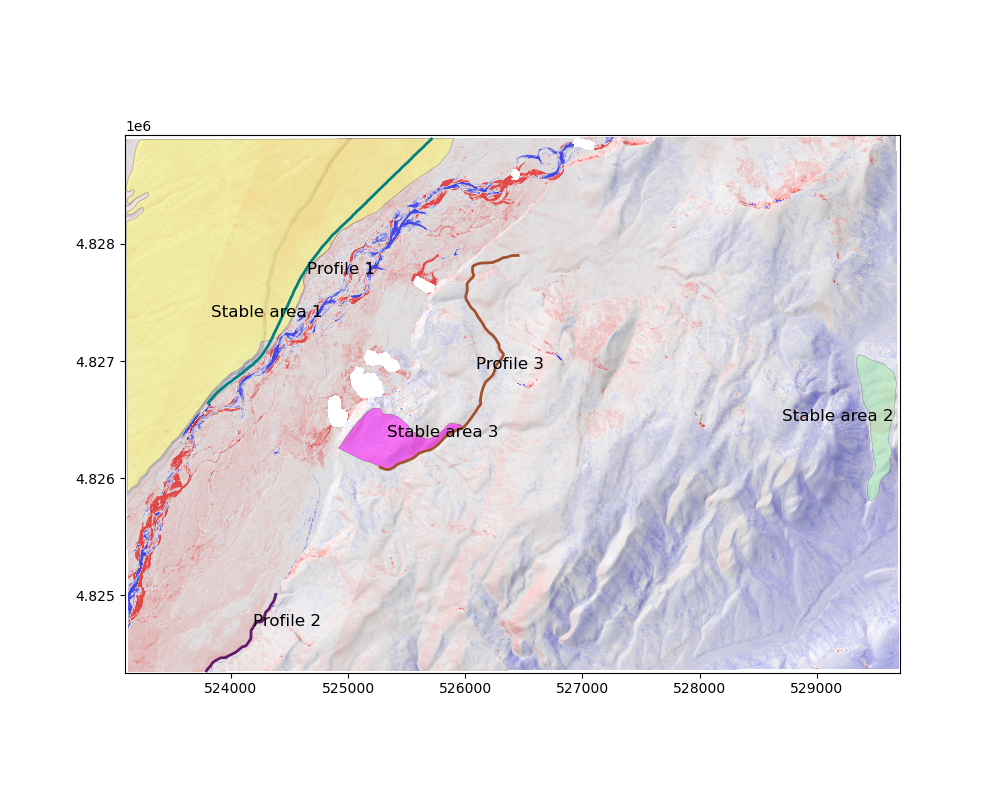

In [94]:
# Load topographic and hillshade raster data
diff_path = data_path + "vertical_differencing.tif"
hillshade_path = data_path + "compare_hillshade.tif"

with rasterio.open(diff_path) as diff:
    topo_diff = diff.read(1, masked=True)
    diff_extent = [diff.bounds.left, diff.bounds.right, diff.bounds.bottom, diff.bounds.top]
    topo_diff_mask = np.ma.getmask(topo_diff)  # Extract mask from topo_diff
    topo_mask = diff.read_masks(1)
    
with rasterio.open(hillshade_path) as data:
    hillshade = data.read(1, masked=True)
    hill_mask = data.read_masks(1) 

# Combine the masks from both datasets
combined_mask = np.logical_not(np.logical_and(topo_mask, hill_mask))

# Apply the combined mask to both datasets
topo_diff = np.ma.masked_where(combined_mask, topo_diff, np.nan)
hillshade = np.ma.masked_where(combined_mask, hillshade, np.nan)

# Define figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the topographic differencing with colormap
vmin, vmax = -0.5, 0.5 # Define your own min and max based on your data range
cmap_diff = plt.get_cmap('bwr_r')
cmap_diff.set_bad(color='none')
norm = Normalize(vmin=vmin, vmax=vmax)
ax.imshow(topo_diff, cmap=cmap_diff, norm=norm, extent=diff_extent)

# Overlay the hillshade with the differencing results as a transparency layer
cmap_shade = plt.get_cmap('gray')
cmap_shade.set_bad(color='none')
ax.imshow(hillshade, cmap=cmap_shade, alpha=0.4, extent=diff_extent)

# Initialize list for adjust_text
texts = []

# Plot profiles and label them
profile_colors = ["teal", "#5f1b6b", "sienna"]
for i, road in enumerate(roads):
    gdf = roads[road]
    gdf.plot(ax=ax, color=profile_colors[i], linewidth=2)  # Use same ax
    label = f"Profile {i+1}"
    x, y = np.median(gdf['geometry'][0].xy[0]), np.median(gdf['geometry'][0].xy[1])
    texts.append(plt.text(x, y, label, fontsize=12, color='k'))  

# Plot stable areas and label them
stable_area_colors = ["#fffe71", "#9be5aa", "fuchsia"]
for i, stable in enumerate(stable_areas):
    gdf = stable_areas[stable]
    gdf.plot(ax=ax, color=stable_area_colors[i], alpha=0.5, edgecolor='black', linewidth=0.25)  # Use same ax
    label = f"Stable area {i+1}"
    x, y = gdf['geometry'].representative_point().x[0], gdf['geometry'].representative_point().y[0]
    texts.append(plt.text(x, y, label, fontsize=12, color='k'))  

adjust_text(texts, ax=ax, expand_points=(1.2, 1.2), expand_text=(1.1, 1.1),
            force_text=(0.5, 0.5), force_points=(0.5, 0.5),
            autoalign='y', only_move={'points':'y', 'text':'y', 'objects':'y'})

# Display the plot
plt.show()

# Estimate systematic error

## Extract differencing data along profiles

#### Function

In [9]:
def interpolate_line(line, distance):
    """
    Create points at specified intervals along a line.

    Parameters:
    - line (LineString): The LineString to interpolate.
    - distance (float): The distance between points.

    Returns:
    - list: List of Point geometries along the line.
    """
    num_segments = int(line.length / distance)
    points = [line.interpolate(distance * i) for i in range(num_segments + 1)]
    return points

In [176]:
def raster_values_along_line(raster_path, points):
    """
    Extract raster values for every cell crossed by a LineString.

    Parameters:
    - raster_path (str): Path to the raster file.
    - points (dict): Dictionary of interpolated points along Linestring. Keys are individual features.

    Returns:
    - list: Values from the raster where the LineString crosses cells.
    """
    

#### Usage

In [256]:
# Get raster resolution
with rasterio.open(diff_path) as src:
    res = src.res[0] 
    
#Interpolate points along the Linestrings at that resolution

points = {}

for i, road in enumerate(roads):
    line = roads[road]['geometry'][0]

    key = f"{road}"
        
    points[key] = interpolate_line(line, res)

In [253]:
raster_values = {}
unique_points = {}
with rasterio.open(diff_path) as src:  
# Get the transformation object from the dataset
    transform = src.transform  
    for i, point in enumerate(points):
        
        list_point = points[f"{point}"]

        # Transform the points into raster space coordinates
        raster_space_coords = [src.index(p.x, p.y) for p in list_point]

        # Remove duplicate coordinates and read the values
        #unique_coords = list(set(raster_space_coords))  # Remove duplicates to avoid multiple readings of the same cell
        
        values_temp = [src.read(1)[coord[1], coord[0]] for coord in raster_space_coords if 0 <= coord[0] < src.width and 0 <= coord[1] < src.height]
        
        # Convert raster space coordinates back to geographical coordinates using the affine transform
        #geo_coords = [transform * (coord[0], coord[1]) for coord in unique_coords]

        key = f"{point}"
        
        # Convert geographical coordinates to Shapely points
        #unique_points[key] = [Point(xy) for xy in geo_coords]
        
        raster_values[key] = values_temp

In [254]:
def calculate_cumulative_distance(points):
    """
    Calculate the cumulative distance along a path defined by a list of shapely points.

    Parameters:
    - points (list of shapely.geometry.Point): The list of points defining the path.

    Returns:
    - list: A list of cumulative distances where each index corresponds to the distance from
            the start to the point at that index.
    """
    if not points:
        return []

    # Initialize the list of distances with the first distance as 0 (since it's the starting point)
    cumulative_distances = [0.0]

    # Iterate over the list of points and calculate distances
    for i in range(1, len(points)):
        # Calculate distance from the previous point
        distance = points[i].distance(points[i - 1])
        # Add this distance to the last cumulative distance in the list
        cumulative_distances.append(cumulative_distances[-1] + distance)

    return cumulative_distances

In [258]:
distances = {}
for i, point in enumerate(points):
     list_point = points[f"{point}"]
     
     distance = calculate_cumulative_distance(list_point)
     
     key = f"{point}"
            
     distances[key] = distance

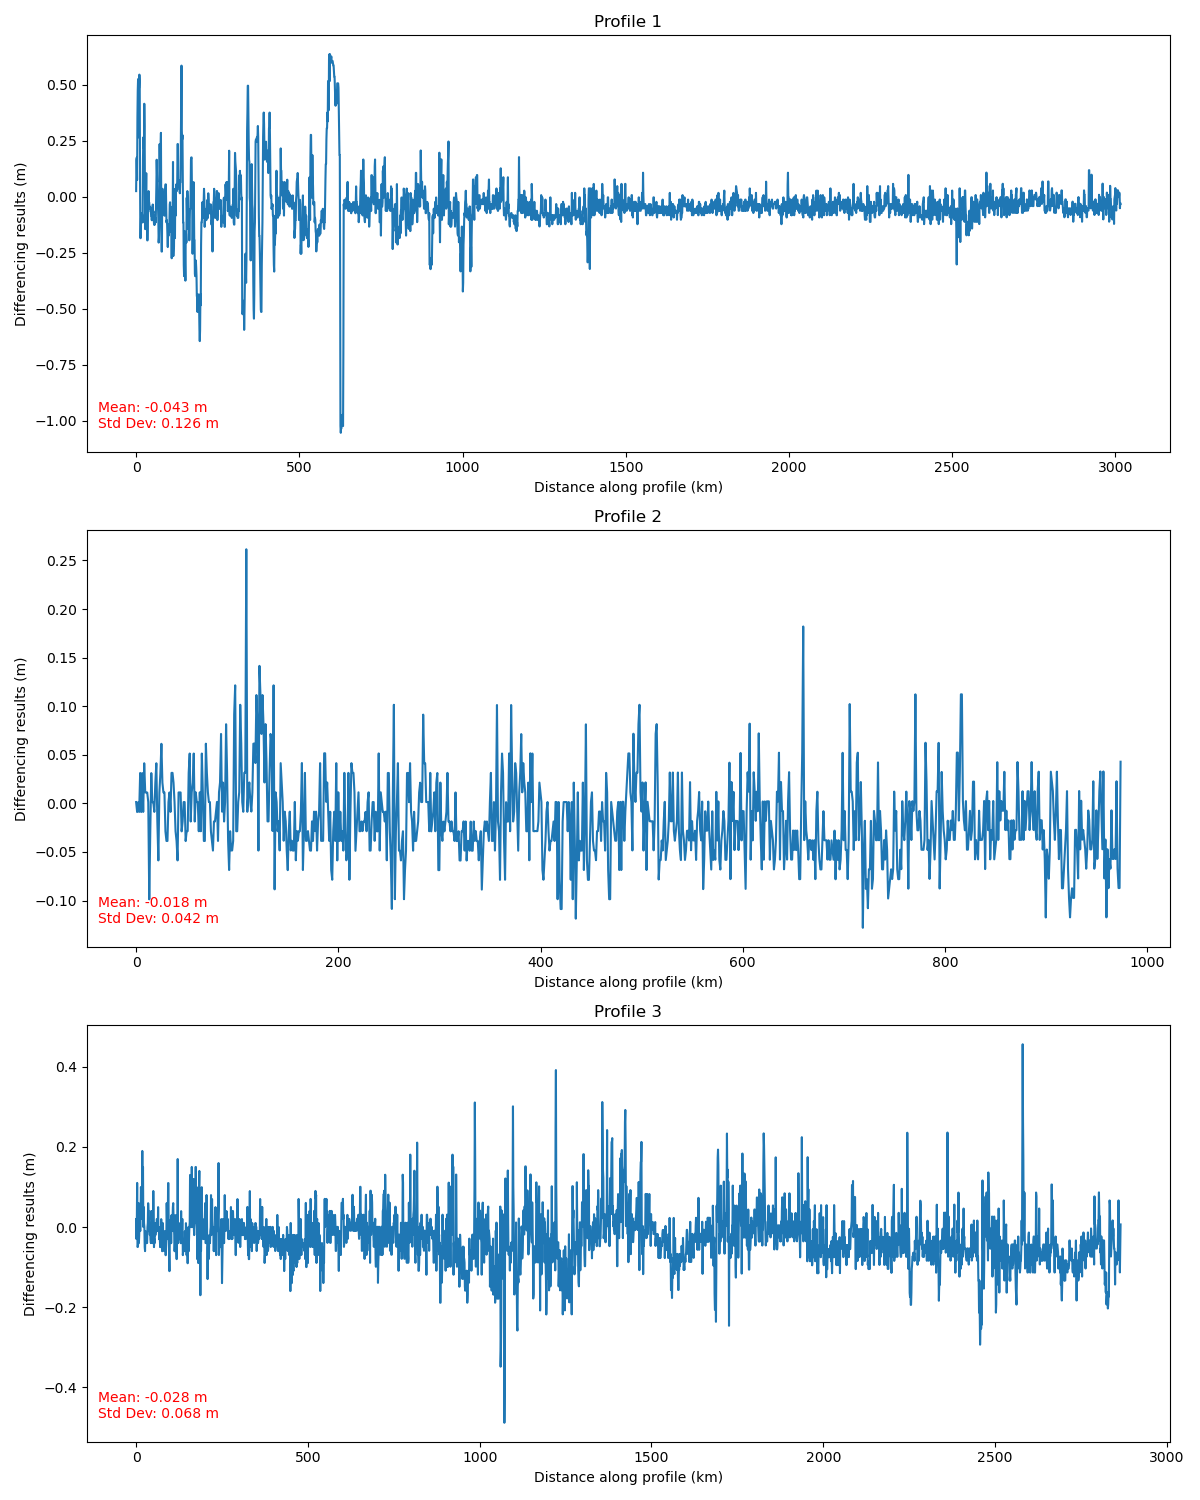

In [262]:
n_profiles = len(roads.keys())

# Create a grid of subplots
fig, axes = plt.subplots(n_profiles, 1, figsize=(12, n_profiles * 5), sharex=False) 

if n_profiles == 1:
    axes = [axes]

# Plot each profile in a separate subplot
for i, ax in enumerate(axes):
    # Filter data for the current profile
    keys = list(points.keys())
    profile_diff = raster_values[keys[i]]
    profile_distance = distances[keys[i]]
    
    # Calculate mean and standard deviation
    mean_val = np.mean(profile_diff)
    std_val = np.std(profile_diff)
    
    # Use Seaborn to plot
    sns.lineplot(ax=ax, x=profile_distance, y=profile_diff, linestyle='-')
    ax.set_title(f'Profile {i + 1}')
    ax.set_ylabel('Differencing results (m)')
    ax.set_xlabel('Distance along profile (km)')

    # Display the mean and standard deviation on the plot
    ax.text(0.01, 0.05, f'Mean: {mean_val:.3f} m\nStd Dev: {std_val:.3f} m', transform=ax.transAxes, 
            verticalalignment='bottom', horizontalalignment='left', fontsize=10, color='red')

plt.tight_layout()
plt.show()

## Estimate correlated error

In [2]:
import rasterio
from rasterio.mask import mask
import os
from shapely.geometry import mapping

def clip_rasters_by_polygons(raster_path, polygons, output_dir):
    """
    Clips a raster into multiple rasters based on a list of Shapely polygons with error handling for non-overlapping polygons.

    Parameters:
    - raster_path (str): Path to the input raster.
    - polygons (list of shapely.geometry.Polygon): List of polygon geometries to clip the raster.
    - output_dir (str): Directory where the clipped rasters will be saved.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Open the raster
    with rasterio.open(raster_path) as src:
        for i, poly in enumerate(polygons):
            # Convert the polygon into GeoJSON format
            geo = [mapping(poly)]

            try:
                # Perform the clipping
                out_image, out_transform = mask(src, geo, crop=True, all_touched=True)

                if out_image.size == 0:
                    raise ValueError("The polygon does not overlap with the raster or results in an empty raster.")

                # Update the metadata of the raster
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })
                
                # Save the resulting raster
                out_raster_path = os.path.join(output_dir, f"stable_raster_{i+1}.tif")
                with rasterio.open(out_raster_path, "w", **out_meta) as dest:
                    dest.write(out_image)
            
            except Exception as e:
                print(f"Failed to clip raster with polygon index {i}: {e}")


In [4]:
output_dir = data_path+"stable_rasters/"
polygons = [stable_areas[a]['geometry'][0] for a in stable_areas.keys()]

clip_rasters_by_polygons(diff_path, polygons, output_dir)

NameError: name 'stable_areas' is not defined

### Variography

In [5]:
from itertools import combinations_with_replacement
from scipy.special import kv, gamma
import numpy as np
from scipy.optimize import curve_fit

In [6]:
def sample_raster(raster, samples_per_sq_km, max_samples):
    """
    Samples the raster data based on a given density (samples per square kilometer) and a maximum number of samples to limit analysis time.
    Returns the sampled values and their corresponding coordinates, with no data values represented as NaN.

    Parameters:
    -----------
    samples_per_sq_km : int
        The desired number of samples per square kilometer.
    max_samples : int
        The maximum number of samples to be taken.

    Returns:
    --------
    samples : numpy.ndarray
        An array of sampled vertical differencing values (in m) from the raster data, with NaN for no data values.
    coords : numpy.ndarray
        The coordinates corresponding to each sampled value.
    """
    with rasterio.open(raster) as src:
        data = src.read(1)  # Read the first band
        nodata = src.nodata  # Get the nodata value from the raster

        # Replace nodata values with NaN in the numpy array
        data = np.where(data == nodata, np.nan, data)

        # Create a mask where data is not NaN (valid data points)
        valid_data_mask = ~np.isnan(data)
        
        cell_size, cell_area_sq_km = src.res[0], (src.res[0] ** 2) / 1e6
        valid_data_points = np.sum(valid_data_mask)
        
        # Calculate total number of samples based on area and sample density, without exceeding the number of valid data points
        total_samples = min(int(cell_area_sq_km * samples_per_sq_km * valid_data_points), max_samples)

        if total_samples > valid_data_points:
            raise ValueError("Requested samples exceed valid data points.")
        
        # Randomly choose indices from the valid data points
        chosen_indices = np.random.choice(np.where(valid_data_mask.ravel())[0], size=total_samples, replace=False)
        
        # Extract samples and coordinates for the chosen indices
        samples = data.ravel()[chosen_indices]
        coords = np.array([src.xy(index // data.shape[1], index % data.shape[1]) for index in chosen_indices])

        return samples, coords

In [69]:
class VariogramAnalysis:
    """
    A class to perform variogram analysis on raster data. It calculates mean variograms, 
    fits spherical models to the variogram data, and plots the results.

    Attributes:
    -----------
    mean_variogram : numpy.ndarray
        The mean variogram calculated from multiple runs.
    lags : numpy.ndarray
        The distances (lags) at which the variogram is calculated.
    mean_count : numpy.ndarray
        The mean count of data pairs used for each lag distance.
    err_variogram : numpy.ndarray
        The standard deviation of the variogram values across multiple runs.
    fitted_variogram : numpy.ndarray
        The variogram values fitted using a model.
    rmse : float
        The root mean square error of the fitted model.
    sills : list
        The sill values of the fitted spherical model components.
    ranges : list
        The range values of the fitted spherical model components.
    err_param : numpy.ndarray
        The standard error of the parameters of the fitted model.
    initial_guess : list
        The initial guess parameters for the fitting process.

    Methods:
    --------
    calculate_mean_variogram(n_bins, n_runs)
        Calculates the mean variogram and its error from multiple runs.
    plot_3_spherical_models_no_nugget()
        Plots the mean variogram and its error
    """
    def __init__(self):
       
        self.mean_variogram = None
        self.lags = None
        self.mean_count = None
        self.err_variogram = None
        self.fitted_variogram = None
        self.rmse_filtered = None
        self.rmse = None
        self.sills = None
        self.ranges = None
        self.err_param = None
        self.err_ranges = None
        self.err_sills = None
        self.initial_guess = None
        self.ranges_min = None
        self.ranges_max = None
        self.sills_min = None
        self.sills_max = None
        self.list_models = None
        self.model_combinations = None
        self.model_functions = None
        self.model_defaults = None
        self.all_popt = None
        self.all_pcov = None
        self.all_params = None
        self.all_rmse = None
        self.all_y_pred = None
        
    def calculate_mean_variogram(self, list_raster, n_bins, n_runs):
        """
        Calculates the mean variogram and its error from multiple sampling and calculation runs.

        Parameters:
        -----------
        n_bins : int
            The number of bins to divide the distance range into for variogram calculation.
        n_runs : int
            The number of runs to perform for sampling and variogram calculation.
        """
        all_variograms = np.zeros((n_runs, n_bins-1))  
        bin_widths = np.zeros(1)
        min_distances = np.zeros(1)
        max_distances = np.zeros(1)
        counts = np.zeros((n_runs, n_bins-1))

        for run in range(n_runs):
            samples = []
            coords = []
            for raster in list_raster:
                # Sample raster
                samples_temp, coords_temp = sample_raster(raster,1000,100000)
                samples.append(samples_temp)
                coords.append(coords_temp)
            
            if run == 0:
                bin_width, min_distance, max_distance = variogram_tools.calculate_bin_width_multiple(coords, n_bins)
                # Calculate variogram for this run
                variogram, count = variogram_tools.dowd_estimator_multiple_cy(coords, samples, n_bins, bin_width, min_distance, max_distance)
                # Store the results
                all_variograms[run, :] = variogram
                counts[run, :] = count
                bin_widths[run] = bin_width
                min_distances[run] = min_distance
                max_distances[run] = max_distance
            else:
                # Calculate variogram for this run
                variogram, count = variogram_tools.dowd_estimator_multiple_cy(coords, samples, n_bins, bin_widths[0], min_distances[0], max_distances[0])
                # Store the results
                all_variograms[run, :] = variogram
                counts[run, :] = count
                
        # Calculate mean and std dev of variograms across all runs
        self.mean_variogram = np.mean(all_variograms, axis=0)
        self.mean_count = np.mean(counts, axis=0)
        self.err_variogram = np.std(all_variograms, axis=0)
        
        # Assuming bin_widths are similar across runs, use the first one to calculate bin lags
        self.lags = np.linspace(min_distances[0] + bin_widths[0] / 2, max_distances[0] - bin_widths[0] / 2, n_bins - 1)
    
    @staticmethod
    def gaussian(h, sill, range):
        return sill * (1 - np.exp(- (h ** 2) / (2 * range ** 2)))

    @staticmethod
    def spherical(h, sill, range):
        return np.where(h <= range, sill * (1.5 * h / range - 0.5 * (h / range) ** 3), sill)

    @staticmethod
    def hole_effect(h, sill, range):
        return sill * (1 - np.cos(2 * np.pi * h / range))

    @staticmethod
    def matern(h, sill, range, nu):
        part1 = 2 ** (1 - nu) / gamma(nu)
        part2 = (h / range) ** nu
        part3 = kv(nu, h / range)
        return sill * (1 - part1 * part2 * part3)

    @staticmethod
    def exponential(h, sill, range):
        return sill * (1 - np.exp(- h / range))

    @staticmethod
    def power(h, scale, exponent):
        return scale * h ** exponent

    @staticmethod
    def linear(h, slope):
        return slope * h

    @staticmethod
    def logarithmic(h, scale):
        # Avoid log(0) by replacing zero distances with a very small value
        h = np.where(h == 0, 1e-50, h)
        return scale * np.log(h)

    @staticmethod
    def noop(h, *args, **kwargs):
        """Function for 'None' model, which does nothing."""
        return np.zeros_like(h)
    
    def define_model(self, number_of_models):
        #self.list_models=["gaussian","hole-effect","matern","exponential","spherical","power","linear","logarithmic","None"]
        self.list_models=["gaussian","matern","exponential","spherical","power","linear","logarithmic","None"]

        self.model_combinations = list(combinations_with_replacement(self.list_models, number_of_models))

        self.model_functions = {
            "gaussian": self.gaussian,
            #"hole-effect": self.hole_effect,
            "matern": self.matern,
            "exponential": self.exponential,
            "spherical": self.spherical,
            "power": self.power,
            "linear": self.linear,
            "logarithmic": self.logarithmic,
            "None": self.noop
            
        }

        self.model_defaults = {
            "gaussian": {"params": ["sill", "range"], "base_guess": [np.max(self.mean_variogram)/4, np.max(self.lags)/8], "bounds": [(0, np.max(self.mean_variogram)*10), (0, np.max(self.lags)*3)]},
            "spherical": {"params": ["sill", "range"], "base_guess": [np.max(self.mean_variogram)/4, np.max(self.lags)/8], "bounds": [(0, np.max(self.mean_variogram)*10), (0, np.max(self.lags)*3)]},
            "exponential": {"params": ["sill", "range"], "base_guess": [np.max(self.mean_variogram)/4, np.max(self.lags)/8], "bounds": [(0, np.max(self.mean_variogram)*10), (0, np.max(self.lags)*3)]},
            "hole-effect": {"params": ["sill", "range"], "base_guess": [np.max(self.mean_variogram)/4, np.max(self.lags)/8], "bounds": [(0, np.max(self.mean_variogram)*10), (0, np.max(self.lags)*3)]},
            "matern": {"params": ["sill", "range", "nu"], "base_guess": [np.max(self.mean_variogram)/4, np.max(self.lags)/8, 0.5], "bounds": [(0, np.max(self.mean_variogram)*10), (0, np.max(self.lags)*3), (0.1, 2)]},
            "power": {"params": ["scale", "exponent"], "base_guess": [0.5, 1.5], "bounds": [(0, 1), (1, 2)]},  
            "linear": {"params": ["slope"], "base_guess": [0.1], "bounds": [(0, 1)]},  
            "logarithmic": {"params": ["scale"], "base_guess": [0.5], "bounds": [(0, 1)]},  
            "None": {"params": [], "base_guess": [], "bounds": []}
        }
        
    def adjust_range_based_on_order(self, combination):
        """
        Adjusts initial guesses and bounds for model parameters based on their order in the combination.
        Specifically, the range parameters are adjusted to increase depending on their position.
        
        Parameters:
        - model_defaults: Dictionary with model configurations.
        - combination: List of model names in the combination.
        
        Returns:
        - Tuple of (initial_guesses, bounds) for the combination.
        """
        initial_guesses = []
        bounds_lower = []
        bounds_upper = []
        range_multiplier = 1
        params=[]
        
        for model_name in combination:
            model = self.model_defaults[model_name]
            if model_name != "None":
                # Adjust range based on its order among models with a range parameter
                base_guess = np.array(model["base_guess"])
                params_ = model["params"]
                if "range" in model["params"]:
                    base_guess[model["params"].index("range")] *= range_multiplier
                    range_multiplier += 1  # Prepare for the next model with a range
                
                # Append adjusted base guesses
                initial_guesses.extend(base_guess)

                params.append(params_)
                
                # Append bounds directly (adjustment for range bounds is not specified but could be added similarly)
                model_bounds = model["bounds"]
                bounds_lower.extend([bound[0] for bound in model_bounds])
                bounds_upper.extend([bound[1] for bound in model_bounds])

        # Combine lower and upper bounds into a list of tuples
        bounds = (bounds_lower, bounds_upper)

        return initial_guesses, bounds, params
    
    def summed_model(self,h, *params,combination_sequence):
        variogram_sum = np.zeros_like(h)
        param_index = 0  # Tracks the current index in the flat parameter list

        for model_name in combination_sequence:
            if model_name == "None":
                continue

            num_params = len(self.model_defaults[model_name]["params"])  # Get number of parameters required by the model
            model_params = params[param_index:param_index + num_params]  # Extract params for the current model

            # Call the model function with extracted parameters
            model_func = self.model_functions[model_name]
            variogram_sum += model_func(h, *model_params)

            param_index += num_params  # Move to the next segment of parameters for the next model

        return variogram_sum
    
    def get_rmse_and_params(self):
        all_popt = []
        all_pcov = []
        all_params = []
        all_rmse = []
        all_y_pred = []
        
        #weights=self.err_variogram#/self.mean_count
        weights=self.err_variogram
        weights=np.where(weights == 0, 1.1111e-50,weights)

        for combo in self.model_combinations[:-1]:
            try:
                initial_guesses, bounds, params = self.adjust_range_based_on_order(combo)
                all_params.append(params)

                # Adjusted curve_fit call within a try-except block
                popt, pcov = curve_fit(
                lambda h, *params: self.summed_model(h, *params, combination_sequence=combo),
                self.lags, self.mean_variogram, p0=initial_guesses, bounds=bounds, maxfev=10000, nan_policy='omit'
                )

                all_popt.append(popt)
                all_pcov.append(pcov)
                
                # Calculate RMSE for the current model and append to all_rmse
                y_pred = self.summed_model(self.lags, *popt, combination_sequence=combo)
                rmse = np.sqrt(np.mean((self.mean_variogram - y_pred) ** 2))
                all_rmse.append(rmse)
                all_y_pred.append(y_pred)

            except RuntimeError as e:
                print(f"Optimization failed for combination {combo}: {e}")
                # Append NaN to maintain alignment with model_combinations
                all_popt.append(np.nan)
                all_pcov.append(np.nan)
                all_rmse.append(np.nan)
                continue  # Proceed to the next iteration
        
        self.all_popt = all_popt
        self.all_pcov = all_pcov
        self.all_params = all_params
        self.all_rmse = all_rmse
        self.all_y_pred = all_y_pred
    
       
    def get_param_df(self,cof,combo):
        list_df = []
        i = 0
        for model in combo:
            # For models that expect 1 parameter
            if model in ["None"]:
                continue
            elif model in ["linear"]:
                df = pd.DataFrame()
                df = df.assign(model=[model], slope=[cof[i]])
                i += 1
            elif model in ["logarithmic"]:
                df = pd.DataFrame()
                df = df.assign(model=[model], scale=[cof[i]])
                i += 1
            # For models that expect 2 parameters
            elif model in ["spherical", "gaussian", "exponential", "hole-effect"]:
                df = pd.DataFrame()
                df = df.assign(model=[model], psill=[cof[i]], range=[cof[i + 1]])
                i += 2
            elif model in ["power"]:
                df = pd.DataFrame()
                df = df.assign(model=[model], scale=[cof[i]], exponent=[cof[i + 1]])
                i += 2
            # For models that expect 3 parameters
            elif model in ["matern"]:
                df = pd.DataFrame()
                df = df.assign(model=[model], psill=[cof[i]], range=[cof[i + 1]], smooth=[cof[i + 2]])
                i += 3
            list_df.append(df)
    
        df_params = pd.concat(list_df).reset_index(drop=True)
        
        sum_model = self.summed_model(self.lags, *cof,combination_sequence=combo)
        
        return df_params, sum_model
    
    def plot_empirical_variogram(self):
        """
        Plots the mean variogram with error bars.
        """
        condition = self.mean_count > np.max(self.mean_count)/5 
        
        lags = self.lags#[condition]
        mean_variogram = self.mean_variogram#[condition]
        err_variogram = self.err_variogram#[condition]
        
        fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(10, 8))

        # Histogram of semivariance counts
        ax[0].bar(self.lags, self.mean_count, width=np.diff(self.lags)[0]*0.9, color='orange', alpha=0.5)
        ax[0].set_ylabel('Mean Number\nof Pairs')

        # Plot mean variogram with error bars indicating spread over the 10 runs
        ax[1].errorbar(lags, mean_variogram, yerr=err_variogram, fmt='o-', color='blue', label='Mean Variogram with Spread')
       
        ax[1].set_xlabel('Lag Distance'), ax[1].set_ylabel('Semivariance')
        ax[1].legend()
        
        plt.setp(ax[0].get_xticklabels(), visible=False)
        plt.tight_layout()
        
        plt.show()

In [70]:
list_rasters = [output_dir+filename for filename in os.listdir(output_dir) if filename.endswith('.tif') and "stable_raster" in filename]

#Create variogram analysis instance based on modified raster
V = VariogramAnalysis()

#Calculate a mean variogram with 75 bins from variograms made over 10 runs
V.calculate_mean_variogram(list_rasters,75,10)

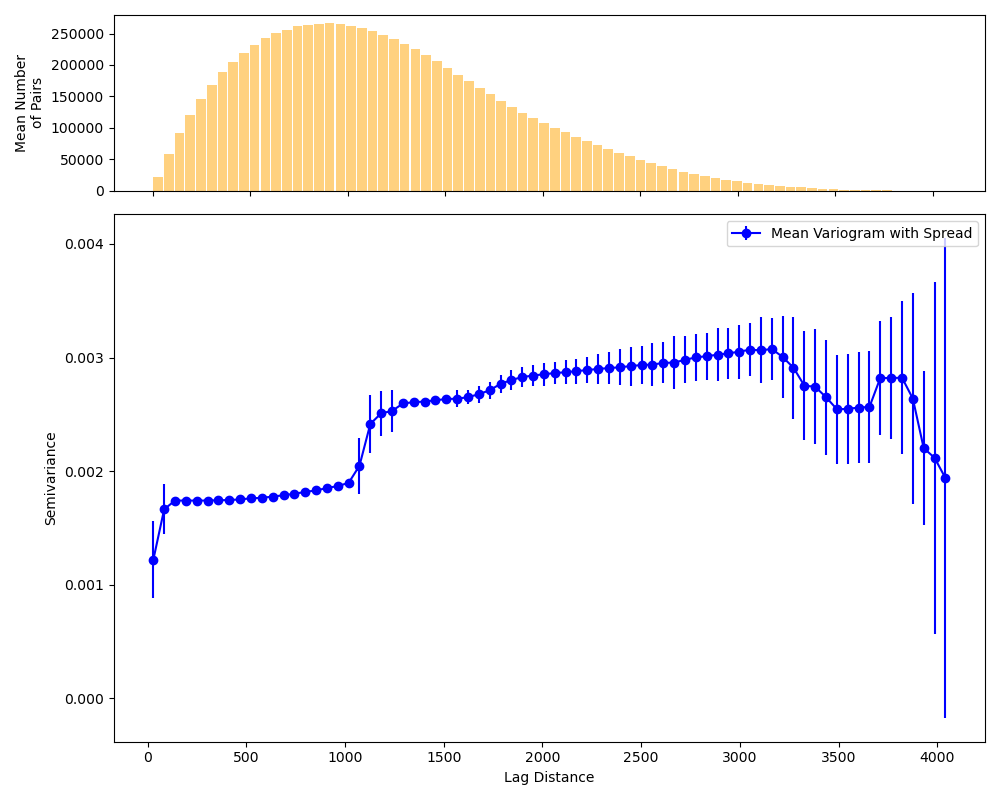

In [72]:
V.plot_empirical_variogram()

In [73]:
V.define_model(4)

V.get_rmse_and_params()

In [74]:
min_rmse_models = V.model_combinations[np.nanargmin(np.array(V.all_rmse))]


In [75]:
min_rmse_models 

('gaussian', 'spherical', 'linear', 'None')

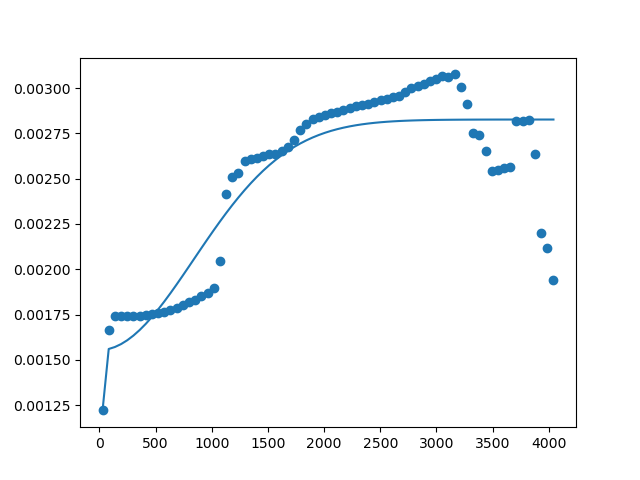

In [77]:
fig,ax=plt.subplots()
ax.scatter(V.lags,V.mean_variogram)
ax.plot(V.lags,V.all_y_pred[np.nanargmin(np.array(V.all_rmse))])

In [78]:
V.all_popt[np.nanargmin(np.array(V.all_rmse))]

array([1.27339007e-03, 8.40173046e+02, 1.55336130e-03, 4.80370315e+01,
       7.85827729e-27])

In [79]:
V.all_params[np.nanargmin(np.array(V.all_rmse))]

[['sill', 'range'], ['sill', 'range'], ['slope']]

In [80]:
combo = V.model_combinations[np.nanargmin(np.array(V.all_rmse))]
cof = V.all_popt[np.nanargmin(np.array(V.all_rmse))]
cov = V.all_pcov[np.nanargmin(np.array(V.all_rmse))]


In [82]:
a, b = V.get_param_df(cof,combo)

In [87]:
# Get total sill
total_sill = np.sum(a["psill"])

# Get function from sum of variogram
sum_variogram = b

def cov(total_sill,sum_variogram):
    return total_sill - sum_variogram

cov = cov(total_sill,sum_variogram)


In [89]:
def rho(cov, total_sill):
    return cov / total_sill

rho = rho(cov, total_sill)

In [90]:
rho

array([5.68255981e-01, 4.48261520e-01, 4.44405764e-01, 4.38701307e-01,
       4.31220297e-01, 4.22056391e-01, 4.11322806e-01, 3.99149987e-01,
       3.85682977e-01, 3.71078543e-01, 3.55502154e-01, 3.39124878e-01,
       3.22120294e-01, 3.04661478e-01, 2.86918151e-01, 2.69054043e-01,
       2.51224531e-01, 2.33574585e-01, 2.16237071e-01, 1.99331408e-01,
       1.82962607e-01, 1.67220673e-01, 1.52180363e-01, 1.37901276e-01,
       1.24428245e-01, 1.11791991e-01, 1.00009999e-01, 8.90875832e-02,
       7.90190772e-02, 6.97891246e-02, 6.13740198e-02, 5.37430623e-02,
       4.68598905e-02, 4.06837664e-02, 3.51707845e-02, 3.02749881e-02,
       2.59493764e-02, 2.21467954e-02, 1.88207048e-02, 1.59258233e-02,
       1.34186530e-02, 1.12578893e-02, 9.40472387e-03, 7.82305068e-03,
       6.47958602e-03, 5.34391322e-03, 4.38846415e-03, 3.58844864e-03,
       2.92174249e-03, 2.36874417e-03, 1.91220919e-03, 1.53707007e-03,
       1.23024881e-03, 9.80467630e-04, 7.78062687e-04, 6.14804359e-04,
      